# PUF Counties Aggregate - Classification 

DeSYNPuf Counties Aggregate with Elixhauser Sums per User & RWJF Factor Rankings Dataset

In [19]:
%matplotlib inline
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.preprocessing as pre

The file contains aggregated Medicare data from 2008-2010 (DeSYNPuf Synthetic Public Use Files), and RWJF County Health Factors and Outcomes Ranking Data from 2010.

2694 out of 3012 counties will be analyzed.


In [25]:
medicare_counties = pd.read_csv("/home/kylier/python/DS/data/PUF/PUF_RWJF_MERGED1.csv")
medicare_counties.shape


(2947, 73)

## Remove a minimal # of outliers.

In [26]:
medicare_counties = medicare_counties[medicare_counties["TOT_COST_PB"]<200000]
medicare_counties = medicare_counties[medicare_counties["CNTY_BENE_USRS"]>0]

medicare_counties.shape

(2840, 73)

In [27]:
medicare_counties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2840 entries, 38 to 2946
Data columns (total 73 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FIPS_STATE_CODE             2840 non-null   int64  
 1   FIPS_COUNTY_CODE            2840 non-null   int64  
 2   CNTY_BENE_CT                2840 non-null   int64  
 3   CNTY_BENE_USRS              2840 non-null   int64  
 4   CNTY_MEAN_AGE               2840 non-null   float64
 5   CNTY_SEX_PROP               2840 non-null   float64
 6   TOT_CNCR_CASES              2840 non-null   int64  
 7   TOT_STRKETIA_CASES          2840 non-null   int64  
 8   TOT_ESRD_CASES              2840 non-null   int64  
 9   CNTY_TOT_VSTS               2840 non-null   int64  
 10  CNTY_TOT_IP_VSTS            2840 non-null   int64  
 11  CNTY_TOT_OP_VSTS            2840 non-null   int64  
 12  CNTY_TOT_CODES              2840 non-null   float64
 13  CNTY_TOT_PROCS              2840

In [28]:
medicare_counties["SR_TOT_COST_PB"] = np.sqrt(medicare_counties["TOT_COST_PB"])
medicare_counties["SR_TOT_IPDAYS"] = np.sqrt(medicare_counties["TOT_IPDAYS_PU"])

In [29]:
medicare_counties["SR_TOT_COST_PB"].describe()

count    2840.000000
mean      211.937052
std        83.796688
min         3.162278
25%       158.568031
50%       215.473854
75%       264.406390
max       445.368013
Name: SR_TOT_COST_PB, dtype: float64

## Classification

In this notebook, I will show how one can use the Random Forest Classifier to try to predict high cost counties.

A high cost county will be defined as counties where SR[TOT_COST_PB] > 265 (which is the 75% level). 

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

In [31]:
# Again, we will begin with Age, Sex and Race indicators in the model.
# The classification model will rate the importance of the variables after it uses them to make decisions.

medicare_counties.loc[medicare_counties["SR_TOT_COST_PB"]>265, "B_COST"] = 1
medicare_counties.loc[medicare_counties["SR_TOT_COST_PB"]<=265, "B_COST"] = 0


df = medicare_counties[["CNTY_MEAN_AGE", "CNTY_SEX_PROP", "CNTY_USR_PROP", "SR_TOT_IPDAYS", "TOT_ESRD_PREV", 
                        "TOT_STRK_PREV", "TOT_CVRG_MOS_PB_PY", "TOT_RXCVRG_MOS_PB_PY",
                        "TOT_IP_VSTS_PU", "TOT_OP_VSTS_PU", "CODES_PU", "PROCS_PU", "PRVDRS_PU", 
                        "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "HO_PROP_RANK", "HF_PROP_RANK", "B_COST"]]

df = df.dropna()
df.shape

(2840, 19)

In [32]:
df["B_COST"].value_counts()

0.0    2138
1.0     702
Name: B_COST, dtype: int64

In [33]:
train, test = train_test_split(df, test_size=0.25, random_state=121)

train_x = train[["CNTY_MEAN_AGE", "CNTY_SEX_PROP", "CNTY_USR_PROP", "SR_TOT_IPDAYS", "TOT_ESRD_PREV", 
                        "TOT_STRK_PREV", "TOT_CVRG_MOS_PB_PY", "TOT_RXCVRG_MOS_PB_PY",
                        "TOT_IP_VSTS_PU", "TOT_OP_VSTS_PU", "CODES_PU", "PROCS_PU", "PRVDRS_PU", 
                        "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "HO_PROP_RANK", "HF_PROP_RANK"]]
train_y = train["B_COST"]

test_x = test[["CNTY_MEAN_AGE", "CNTY_SEX_PROP", "CNTY_USR_PROP", "SR_TOT_IPDAYS", "TOT_ESRD_PREV", 
                        "TOT_STRK_PREV", "TOT_CVRG_MOS_PB_PY", "TOT_RXCVRG_MOS_PB_PY",
                        "TOT_IP_VSTS_PU", "TOT_OP_VSTS_PU", "CODES_PU", "PROCS_PU", "PRVDRS_PU", 
                        "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "HO_PROP_RANK", "HF_PROP_RANK"]]
test_y = test["B_COST"]

s = pre.StandardScaler()
train_x = s.fit_transform(train_x)
test_x = s.fit_transform(test_x)

train_x = pd.DataFrame(train_x, columns=["CNTY_MEAN_AGE", "CNTY_SEX_PROP", "CNTY_USR_PROP", "SR_TOT_IPDAYS", "TOT_ESRD_PREV", 
                        "TOT_STRK_PREV", "TOT_CVRG_MOS_PB_PY", "TOT_RXCVRG_MOS_PB_PY",
                        "TOT_IP_VSTS_PU", "TOT_OP_VSTS_PU", "CODES_PU", "PROCS_PU", "PRVDRS_PU", 
                        "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "HO_PROP_RANK", "HF_PROP_RANK"])

test_x = pd.DataFrame(test_x, columns=["CNTY_MEAN_AGE", "CNTY_SEX_PROP", "CNTY_USR_PROP", "SR_TOT_IPDAYS", "TOT_ESRD_PREV", 
                        "TOT_STRK_PREV", "TOT_CVRG_MOS_PB_PY", "TOT_RXCVRG_MOS_PB_PY",
                        "TOT_IP_VSTS_PU", "TOT_OP_VSTS_PU", "CODES_PU", "PROCS_PU", "PRVDRS_PU", 
                        "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "HO_PROP_RANK", "HF_PROP_RANK"])



train_x

,CNTY_MEAN_AGE,CNTY_SEX_PROP,CNTY_USR_PROP,SR_TOT_IPDAYS,TOT_ESRD_PREV,TOT_STRK_PREV,TOT_CVRG_MOS_PB_PY,TOT_RXCVRG_MOS_PB_PY,TOT_IP_VSTS_PU,TOT_OP_VSTS_PU,CODES_PU,PROCS_PU,PRVDRS_PU,TOT_CC_PREV,TOT_CC_INCD,TOT_ELIX_PU,HO_PROP_RANK,HF_PROP_RANK
0,-0.729858,-0.262895,0.747347,0.834346,0.165622,-0.039389,0.955315,0.860709,0.715453,-0.259966,0.029110,-0.416061,0.686354,0.456735,0.213309,0.012173,1.371045,0.544515
1,-1.129097,-0.011970,0.181928,0.509831,-0.484579,0.060394,-1.303923,-0.524658,-0.036027,-0.494207,-0.050537,0.018642,0.885336,0.174381,0.004361,0.267322,-1.253922,-1.426189
2,-0.615790,0.301686,0.959379,0.712985,3.091529,0.858659,-0.328884,1.281978,-0.146414,-0.763829,-0.653956,-1.077540,-0.710588,0.648007,0.437182,0.093614,-0.009056,1.204892
3,-0.558756,-0.827475,0.535315,-0.648065,0.165622,-0.338738,0.646156,0.275963,-0.857306,0.737170,0.229229,0.936890,-0.721177,0.620682,-0.010564,-0.498849,-1.319806,-1.457470
4,-6.585360,0.301686,-1.585008,-2.200046,-1.297331,-0.937437,0.955315,-3.584621,-1.691831,0.790460,-0.557957,-0.624332,1.089553,-0.007783,-2.383619,-1.636429,-1.520927,-1.582594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,-0.596779,-1.109765,0.005234,-0.800672,-1.297331,1.307683,0.955315,0.376565,-0.919122,-2.318118,-1.997932,-1.866746,-2.087166,-0.212718,-0.704571,-1.408211,-1.461978,-0.706726
2126,-0.900960,0.301686,-0.428468,1.891779,0.365116,0.695378,-0.406714,0.736672,0.317211,-0.275338,-0.026766,0.055479,0.327141,0.215782,-0.124536,0.333978,-1.063204,-0.546845
2127,-0.368642,0.301686,-0.748039,0.080655,-0.527356,-0.228452,-0.781357,-0.407730,-0.339591,0.110459,-0.161964,-0.061730,1.049844,-0.805949,-0.262716,0.130254,0.365444,0.662687
2128,0.201699,0.084539,1.595476,-0.074243,0.390692,0.444176,0.927874,0.420094,-0.443610,-0.593028,-0.661340,-0.645971,-0.120044,0.685841,0.199532,-0.491477,-0.969579,-1.255881


In [34]:
#The default criterion is "gini". We can also run with criterion "entropy" for information gain,
#rather than impurity
clf = RandomForestClassifier(min_samples_leaf=10, random_state=121)
clf.fit(train_x, train_y)

# predict on test data
prediction = clf.predict(test_x)

# compute evaluation scores
accuracy = accuracy_score(test_y, prediction)
precision = precision_score(test_y, prediction)
recall = recall_score(test_y, prediction)
cm = confusion_matrix(test_y, prediction)
roc = roc_auc_score(test_y, prediction)
f1 = f1_score(test_y, prediction)

In [35]:
accuracy

0.8507042253521127

In [36]:
precision

0.7851851851851852

In [37]:
recall

0.5792349726775956

In [38]:
f1

0.6666666666666666

## Scores

These are great scores for a simple Random Forest Classifier without any boosting.

The meaning of all these scores is worth reading up on.  

Now let's look at the Feature Importances of each of the variables in the model.

<AxesSubplot:>

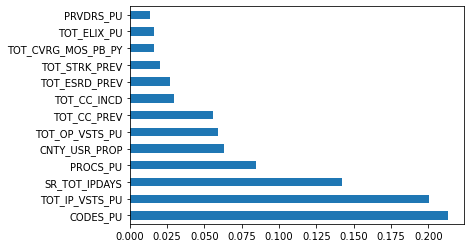

In [39]:
feat_importances = pd.Series(clf.feature_importances_, index=train_x.columns)
feat_importances.nlargest(13).plot(kind='barh')

## Feature Importances

CODES_PU was the most useful variable to the decision tree, in classifying counties into high cost or low cost!

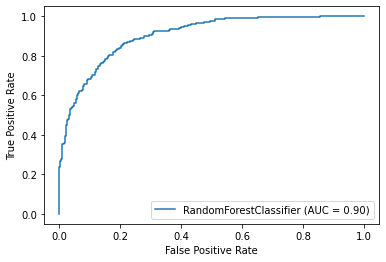

In [40]:
from sklearn.metrics import plot_roc_curve

clf_disp = plot_roc_curve(clf, test_x, test_y)
plt.show()

## AUC

AUC for the holdout (test) data is 0.90!

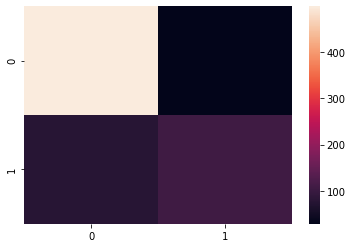

In [41]:
sb.heatmap(cm)
plt.show()

In [42]:
cm

array([[498,  29],
       [ 77, 106]])

## Confusion Matrix

The confusion matrix shows the actual positives and negatives of the target classification (in this case, HIGH_COST) on the left column, plotted against the predicted positives and negatives going across the rows.

Above, the first cell contains TRUE NEGATIVES (times the true value was negative, and the classifier predicted negative).  The classifier correctly predicted 498 out of 527 negative cases.

The second cell contains the FALSE NEGATIVES (times the true value was negative, and the classifier predicted positive).  The classifier incorrectly classified 29 positive cases as positive.

The second row, first cell contains the FALSE NEGATIVES (times the true value was positive, and the classifier predicted negative).  The classifier incorrectly classified 77 positive cases as negative.

The second row, second cell contains the TRUE POSITIVES (times the true value was positive, and the classifier predicted positive high cost).  The classifier correctly predicted 106 out of 183 positive cases.

Performance could be improved if we moved to a boosted classifer.

The confusion matrix values can be used to calculate a wide variety of other important model metrics:

https://en.wikipedia.org/wiki/Confusion_matrix

## Now...

Let's try the whole model using "entropy" criterion instead of "gini" - just for comparison!

In [43]:
clf2 = RandomForestClassifier(criterion="entropy", min_samples_leaf=10, random_state=121)
clf2.fit(train_x, train_y)

# predict on test data
prediction2 = clf2.predict(test_x)

# compute evaluation scores
accuracy2 = accuracy_score(test_y, prediction2)
precision2 = precision_score(test_y, prediction2)
recall2 = recall_score(test_y, prediction2)
cm2 = confusion_matrix(test_y, prediction2)
roc2 = roc_auc_score(test_y, prediction2)
f12 = f1_score(test_y, prediction2)

In [44]:
accuracy2

0.8492957746478873

In [45]:
precision2

0.7753623188405797

In [46]:
recall2

0.5846994535519126

In [47]:
f12

0.6666666666666667

<AxesSubplot:>

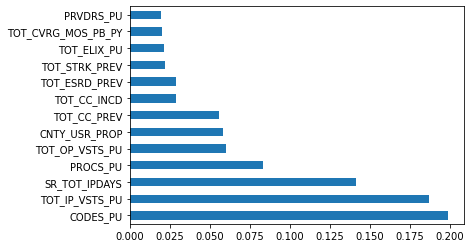

In [48]:
feat_importances2 = pd.Series(clf2.feature_importances_, index=train_x.columns)
feat_importances2.nlargest(13).plot(kind='barh')

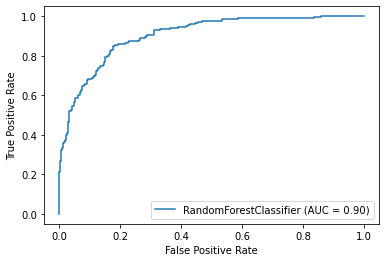

In [49]:
clf_disp2 = plot_roc_curve(clf2, test_x, test_y)
plt.show()

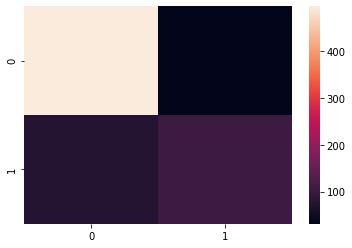

In [50]:
sb.heatmap(cm2)
plt.show()

In [51]:
cm2

array([[496,  31],
       [ 76, 107]])

The entropy model had ONE MORE CORRECT prediction of the positive class.

## Lastly...

What if we tried to classify only the HIGHER THAN PREDICTED rows set using only the new FACTOR variables?

This might not work, but let's see.

In [53]:
mc = pd.read_csv("/home/kylier/python/DS/data/PUF/HIGHER_THAN_PREDICTED_FACTORS.csv")
mc.shape

(975, 80)

In [55]:
mc.drop(columns=mc.columns[0], axis=1, inplace=True, errors="ignore")

In [56]:
mc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 79 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FIPS_STATE_CODE             975 non-null    int64  
 1   FIPS_COUNTY_CODE            975 non-null    int64  
 2   CNTY_BENE_CT                975 non-null    int64  
 3   CNTY_BENE_USRS              975 non-null    int64  
 4   CNTY_MEAN_AGE               975 non-null    float64
 5   CNTY_SEX_PROP               975 non-null    float64
 6   TOT_CNCR_CASES              975 non-null    int64  
 7   TOT_STRKETIA_CASES          975 non-null    int64  
 8   TOT_ESRD_CASES              975 non-null    int64  
 9   CNTY_TOT_VSTS               975 non-null    int64  
 10  CNTY_TOT_IP_VSTS            975 non-null    int64  
 11  CNTY_TOT_OP_VSTS            975 non-null    int64  
 12  CNTY_TOT_CODES              975 non-null    float64
 13  CNTY_TOT_PROCS              975 non

In [57]:
mc["SR_TOT_COST_PB"].describe()

count    975.000000
mean     290.405097
std       54.868432
min      164.833249
25%      249.160936
50%      284.892962
75%      324.827172
max      445.368013
Name: SR_TOT_COST_PB, dtype: float64

## Since these counties are already "Higher than Predicted" cost

Setting the cut-off at the 25% level.

In [59]:
mc.loc[mc["SR_TOT_COST_PB"]>250, "B_COST"] = 1
mc.loc[mc["SR_TOT_COST_PB"]<=250, "B_COST"] = 0

df = mc[["FACTORS_1", "FACTORS_2", "FACTORS_3", "B_COST"]]
train, test = train_test_split(df, test_size=0.25, random_state=121)

train

,FACTORS_1,FACTORS_2,FACTORS_3,B_COST
949,-0.288873,0.289165,-0.187332,1.0
755,-0.055802,0.408960,-0.216046,1.0
127,0.883905,-0.735503,-1.095119,1.0
913,-0.434412,0.192382,0.022423,1.0
136,-0.212793,0.882763,-0.052384,0.0
...,...,...,...,...
500,-0.503050,-0.622275,0.033358,1.0
607,-0.549531,-0.276182,-0.524792,1.0
264,1.486837,0.973190,0.693359,1.0
469,-0.316642,-0.857571,-0.960919,1.0


In [60]:
train_x = train[["FACTORS_1", "FACTORS_2", "FACTORS_3"]]
train_y = train["B_COST"]

test_x = test[["FACTORS_1", "FACTORS_2", "FACTORS_3"]]
test_y = test["B_COST"]

In [61]:
clf3 = RandomForestClassifier(min_samples_leaf=10, random_state=121)
clf3.fit(train_x, train_y)

# predict on test data
prediction3 = clf3.predict(test_x)

# compute evaluation scores
accuracy3 = accuracy_score(test_y, prediction3)
precision3 = precision_score(test_y, prediction3)
recall3 = recall_score(test_y, prediction3)
cm3 = confusion_matrix(test_y, prediction3)
roc3 = roc_auc_score(test_y, prediction3)
f13 = f1_score(test_y, prediction3)

In [62]:
accuracy3

0.7008196721311475

In [63]:
precision3

0.7008196721311475

In [64]:
recall3

1.0

In [65]:
f13

0.8240963855421687

<AxesSubplot:>

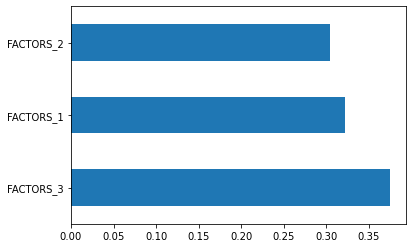

In [66]:
feat_importances3 = pd.Series(clf3.feature_importances_, index=train_x.columns)
feat_importances3.nlargest(3).plot(kind='barh')

## The ROC tells the whole story :-(

**This did not work.**  The Factor Analysis is good for grouping variables and explaining how they vary together, but it isn't always good at helping predict anything.  Particularly when outliers are included and outcome variable has a lot of variance!

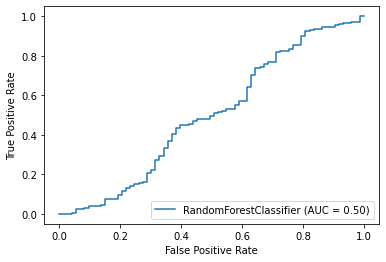

In [67]:
clf_disp3 = plot_roc_curve(clf3, test_x, test_y)
plt.show()

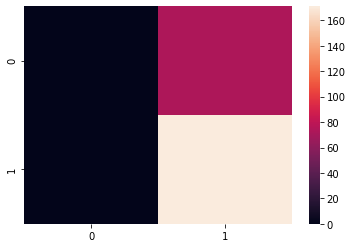

In [68]:
sb.heatmap(cm3)
plt.show()

In [69]:
cm3

array([[  0,  73],
       [  0, 171]])